# Try different architectures

This notebook tries out a few pretrained models from the timm library. 

In [3]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the required libraries

In [4]:
import pandas as pd
from pathlib import Path
import os
## Try CPU fallback for GPU operations not supported by MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *



# fastai library simplifies training fast and accurate neural nets using modern best practices
# https://www.mdpi.com/2078-2489/11/2/108/htm

### Set relative paths

In [5]:
BASE_PATH = Path.cwd().parent.parent


In [6]:
data_path = BASE_PATH / 'data'
path = Path(data_path / "processed")
!ls $path

call      nocall    test_set  train_set


### Get a list of filenames for all the images in the training data path

In [7]:
filenames = get_image_files(path)
filenames

(#1998) [Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-570110-clip-739867.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-294566-clip-583814.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-320824-clip-730198.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-217279-clip-755445.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-100144-clip-349271.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-292199-clip-569065.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectrograms/recording-296236-clip-608515.jpg'),Path('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/call/spectro

In [8]:
def grandparent_label(item):
    "Label `item` with the name of the folder 2 levels up"
    return Path(item).parent.parent.name

# DataBlock
Framework for creating a dataloaders object. 
- blocks is where we specify the types of features and labels : Image as input, 2 category output (call/nocall)
- sampling 20% of the data and using that as the validation set.
- using this framework we can build a __dataloaders__ 


Some of the terminology in PyTorch and fastai can be confusing. They can have similar names which mean very specific things. Here are the definintions

- Dataset: an iterable over tuples containing images with their corresponding category.
- Datasets: a fastai class which joins together a training dataset and a validation dataset into one object.
- DataLoader: a PyTorch iterable returning a batch of datasets.
- DataLoaders: a fastai iterable which splits dataloader into training and validation datasets.
- batch: The sample of the dataset loaded in parallel and passed to the model during one training loop.


In [9]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = grandparent_label)

In [10]:
birds.dataloaders(path)

In [11]:
birds.summary(path)

Setting-up type transforms pipelines
Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/nocall/spectrograms/recording-557012-clip-697311.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/nocall/spectrograms/recording-557012-clip-697311.jpg
    applying grandparent_label gives
      nocall
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(1))


Found 1998 items
2 datasets of sizes 1599,399
Se

This summary shows the two datasets used for training - the larger training set and the smaller validation set. 

In [12]:
dataloaders = birds.dataloaders(path)

In [13]:
x,y = dataloaders.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

- Here we can see the batch size is 64, and contains 3 channel images of 224*224 px 
- The length of the labels is just a tensor containg 64 elements. 
The 3 channel means we're loading these images into the tensor as RGB images instead of greyscale images, which is redundant, though necessary if the pretrained architecture used RGB images. In this case (resnet18 on ImageNet) it did use RGB images. 

# Show 9 items from training set. 
Note this is before any attempt to process the data to include high quality samples, or to curate a no_call dataset which doesn't contain calls of the olive sided flycatcher. This no_call dataset is made from clips tagged as species other than the olive sided flycatcher - but there could still be OSFL calls in the background. 

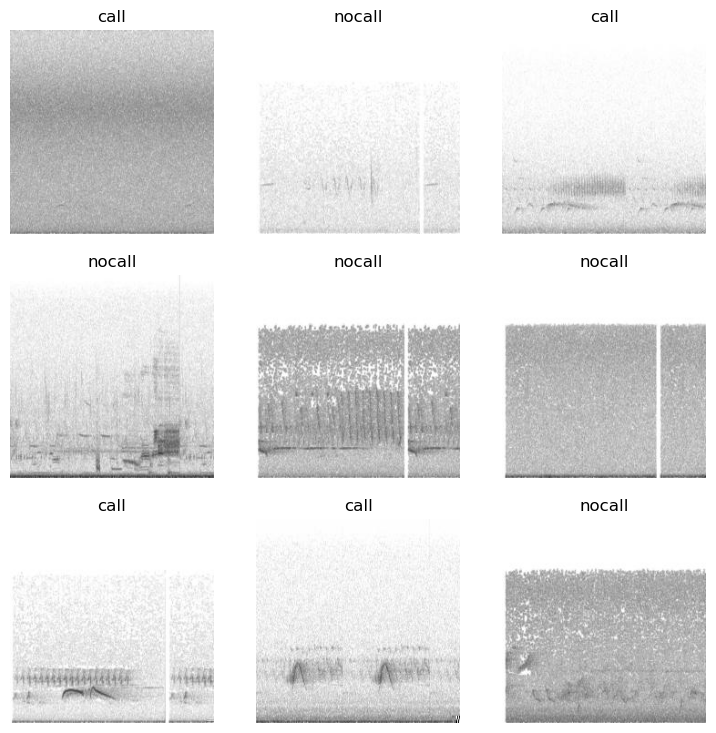

In [14]:
dataloaders.train.show_batch(unique=False)

# Train a model using transfer learning
The model being retranined is a resnet 18 model trained on the imagenet database. 

In [15]:
resnet18??

Signature:
resnet18(
    *,
    weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None,
    progress: bool = True,
    **kwargs: Any,
) -> torchvision.models.resnet.ResNet
Source:   
@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
def resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    """ResNet-18 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

    Args:
        weights (:class:`~torchvision.models.ResNet18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.ResNet18_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvisio

# Random weights
In this training run the model weights are randomly initialized. 

In [16]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate, pretrained=False)

In [17]:
%time learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.124594,2.467526,0.476190,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.919102,0.821288,0.458647,00:37
1,0.754433,0.712646,0.370927,00:37
2,0.630514,1.030956,0.363409,00:37
3,0.519015,0.839889,0.333333,00:37
4,0.425726,1.112396,0.328321,00:39
5,0.321761,1.448828,0.340852,00:38
6,0.254866,1.007752,0.293233,00:37
7,0.181781,0.711099,0.255639,00:37
8,0.131070,0.748523,0.248120,00:37
9,0.098050,0.775473,0.253133,00:37


CPU times: user 1min 4s, sys: 17.7 s, total: 1min 22s
Wall time: 6min 42s


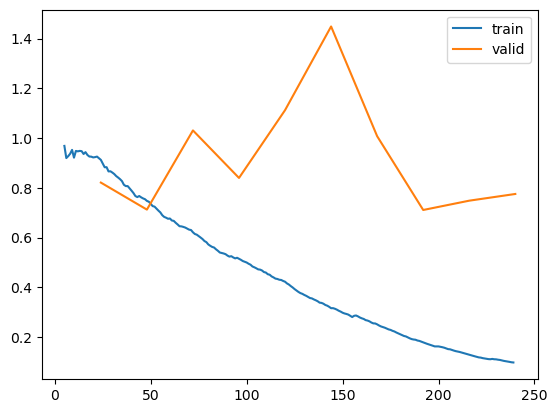

In [18]:
learn.recorder.plot_loss()

In [20]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate, pretrained=True)

In [21]:
%time learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.122820,1.238234,0.406015,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.703679,0.932480,0.315789,00:37
1,0.511573,0.682503,0.240602,00:37
2,0.392464,0.589328,0.195489,00:38
3,0.298657,0.753121,0.220551,00:38
4,0.222477,0.722331,0.225564,00:39
5,0.162274,0.678773,0.195489,00:38
6,0.115323,0.686365,0.190476,00:38
7,0.079414,0.653617,0.180451,00:39
8,0.054161,0.636687,0.190476,00:38
9,0.035615,0.640740,0.185464,00:37


CPU times: user 1min 3s, sys: 18.5 s, total: 1min 22s
Wall time: 6min 47s


# Using pretrained model weights from ImageNet 
(rather than using randomly initialized model weights) 
- made no difference to the loss on the validation set, 
- it did affect the training loss curve - the loss started out low and stayed low

# Using other models from the timm lbrary
- import timm then list available models. 
- can fiter by name
- some of the architectures don't have pretrained weights available.

In [43]:
import timm
# repghostnet architectures with pretrained model weights avaliable
print(timm.list_models('*repghost*', pretrained=True))

['repghostnet_050.in1k', 'repghostnet_058.in1k', 'repghostnet_080.in1k', 'repghostnet_100.in1k', 'repghostnet_111.in1k', 'repghostnet_130.in1k', 'repghostnet_150.in1k', 'repghostnet_200.in1k']


In [44]:

# fastvit architectures with pretrained model weights avaliable
print(timm.list_models('*fastvit*', pretrained=True))


['fastvit_ma36.apple_dist_in1k', 'fastvit_ma36.apple_in1k', 'fastvit_s12.apple_dist_in1k', 'fastvit_s12.apple_in1k', 'fastvit_sa12.apple_dist_in1k', 'fastvit_sa12.apple_in1k', 'fastvit_sa24.apple_dist_in1k', 'fastvit_sa24.apple_in1k', 'fastvit_sa36.apple_dist_in1k', 'fastvit_sa36.apple_in1k', 'fastvit_t8.apple_dist_in1k', 'fastvit_t8.apple_in1k', 'fastvit_t12.apple_dist_in1k', 'fastvit_t12.apple_in1k']


In [47]:

# fastvit architectures with pretrained model weights avaliable
print(timm.list_models('*efficientnetv2*', pretrained=True))


['efficientnetv2_rw_m.agc_in1k', 'efficientnetv2_rw_s.ra2_in1k', 'efficientnetv2_rw_t.ra2_in1k', 'gc_efficientnetv2_rw_t.agc_in1k', 'tf_efficientnetv2_b0.in1k', 'tf_efficientnetv2_b1.in1k', 'tf_efficientnetv2_b2.in1k', 'tf_efficientnetv2_b3.in1k', 'tf_efficientnetv2_b3.in21k', 'tf_efficientnetv2_b3.in21k_ft_in1k', 'tf_efficientnetv2_l.in1k', 'tf_efficientnetv2_l.in21k', 'tf_efficientnetv2_l.in21k_ft_in1k', 'tf_efficientnetv2_m.in1k', 'tf_efficientnetv2_m.in21k', 'tf_efficientnetv2_m.in21k_ft_in1k', 'tf_efficientnetv2_s.in1k', 'tf_efficientnetv2_s.in21k', 'tf_efficientnetv2_s.in21k_ft_in1k', 'tf_efficientnetv2_xl.in21k', 'tf_efficientnetv2_xl.in21k_ft_in1k']


In [49]:
from timm.models.fastvit import fastvit_t8
from timm.models.repghost import repghostnet_050
from timm.models.efficientnet import efficientnetv2_rw_s

# fastvit_t8

In [25]:
learn = vision_learner(dataloaders, fastvit_t8, metrics=error_rate, pretrained=True)
%time learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.145911,0.931486,0.393484,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.780825,0.678540,0.310777,01:00
1,0.752738,0.708993,0.305764,01:00
2,0.718757,0.671143,0.268170,01:01
3,0.686246,0.855340,0.305764,00:58
4,0.623300,0.704132,0.278196,00:57
5,0.554831,0.694992,0.283208,00:59
6,0.488803,0.678223,0.278196,00:59
7,0.429486,0.681072,0.283208,00:59
8,0.386648,0.691503,0.273183,00:59
9,0.363248,0.683228,0.278196,00:58


CPU times: user 3min 28s, sys: 30 s, total: 3min 58s
Wall time: 10min 46s


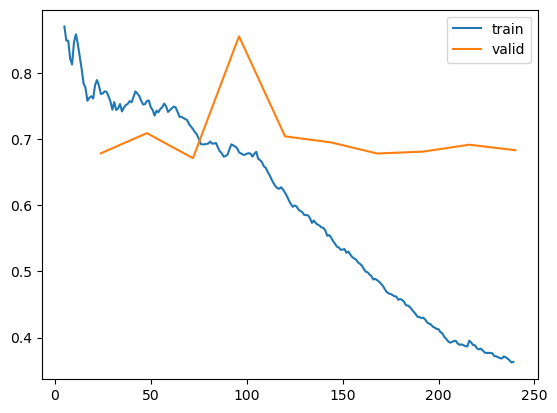

In [26]:
learn.recorder.plot_loss()

# repghostnet
- Wouldnt' train due to one of the callbacks to do with sigmoid not being implemented on MPS - try on CUDA instead

>NotImplementedError: The operator 'aten::hardsigmoid.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [27]:
learn = vision_learner(dataloaders, repghostnet_050, metrics = error_rate, pretrained=True)
%time learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.074274,0.831864,0.290727,00:20


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torch/nn/functional.py:1990: UserWarning: The operator 'aten::hardsigmoid.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1696859373044/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardsigmoid(input)


epoch,train_loss,valid_loss,error_rate,time
0,0.766980,0.766760,0.273183,00:26
1,0.735258,0.615549,0.298246,00:18
2,0.667816,0.639606,0.313283,00:18
3,0.583387,0.622098,0.260652,00:18
4,0.532680,0.627780,0.305764,00:18
5,0.481154,0.594188,0.293233,00:18
6,0.433763,0.640908,0.280702,00:18
7,0.392941,0.611879,0.278196,00:18
8,0.366924,0.637667,0.280702,00:18
9,0.338892,0.634008,0.288221,00:18


CPU times: user 2min 21s, sys: 16.9 s, total: 2min 38s
Wall time: 3min 31s


# Efficientnetv2
- pretty slow to train the 's' small model
- the 't' tiny model requests too much memory 
- try in a cloud environment. 

In [50]:
learn = vision_learner(dataloaders, efficientnetv2_rw_s, metrics = error_rate, pretrained=True)
%time learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.176185,1.180682,0.385965,05:14


epoch,train_loss,valid_loss,error_rate,time
0,0.709753,22067.566406,0.428571,22:47
1,0.565446,0.831507,0.293233,21:15


CPU times: user 1min 13s, sys: 25min 3s, total: 26min 17s
Wall time: 49min 18s


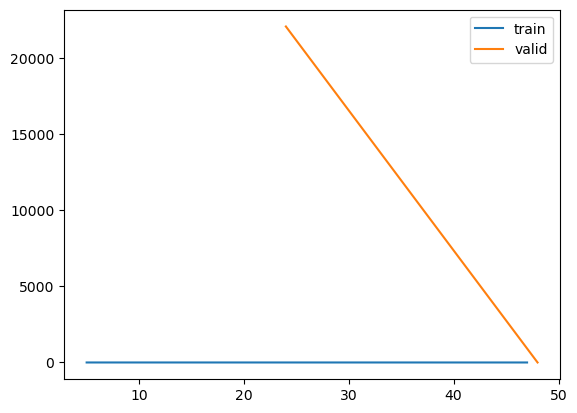

In [51]:
learn.recorder.plot_loss()

### Let's see what happens if we don't allow the model to unfreeze
interrupted early since model was not learning

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.225794,0.829699,0.323308,12:15


epoch,train_loss,valid_loss,error_rate,time
0,0.986062,1.404762,0.398496,14:26
1,0.886916,0.699840,0.290727,13:37
2,0.787763,0.711607,0.303258,13:02


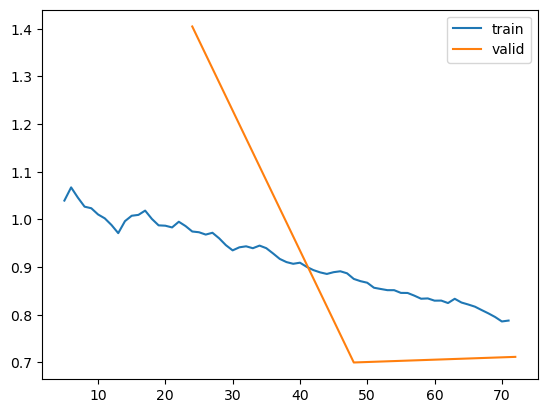

In [70]:
learn = vision_learner(dataloaders, models.efficientnet_v2_s, metrics = error_rate, pretrained=True)
learn.fine_tune(3)
learn.recorder.plot_loss()


In [68]:
models.efficientnet_v2_s(pretrained=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /Users/mikeg/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 68.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### Let's see what happens if we reduce the learning rate after unfreezing the model

epoch,train_loss,valid_loss,error_rate,time
0,1.136735,1.768365,0.458647,00:25


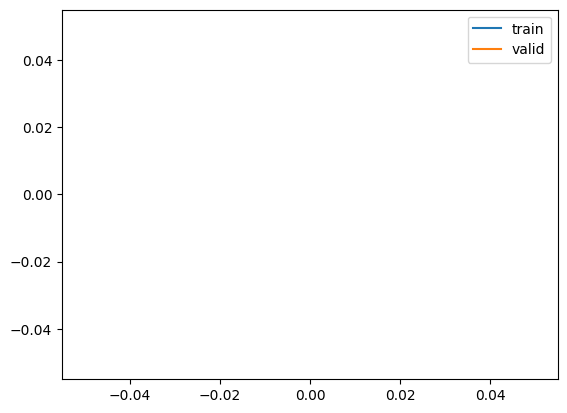

In [ ]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)
learn.fine_tune(0, freeze_epochs=1)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.722889,0.860341,0.255639,00:37
1,0.557235,0.875208,0.243108,00:37
2,0.509914,0.574172,0.185464,00:37
3,0.401941,0.506914,0.160401,00:38
4,0.286258,0.509188,0.160401,00:37
5,0.194585,0.558859,0.160401,00:37
6,0.132048,0.493360,0.155388,00:38
7,0.092755,0.493342,0.147870,00:37
8,0.062294,0.496656,0.145363,00:37


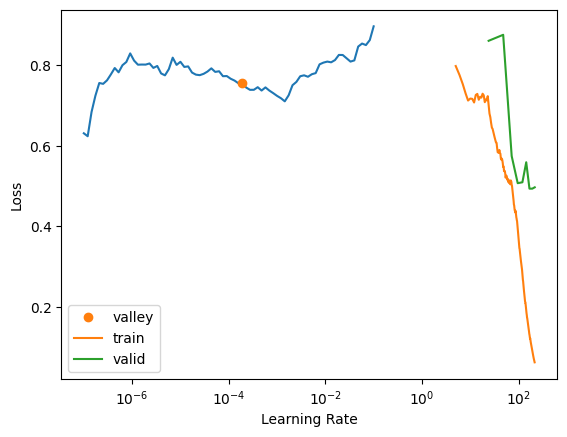

In [ ]:
learn.unfreeze()
lr = learn.lr_find()
learn.fit_one_cycle(9, lr_max = lr)

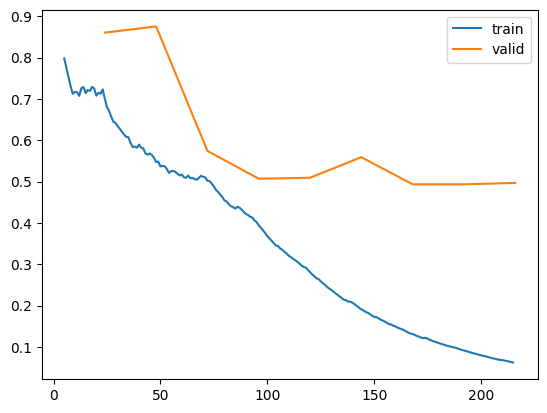

In [ ]:
learn.recorder.plot_loss()

### Here we can see that the initial learning rate of 0.2e-2 was too high for the unfrozen model. Using a learning rate of 0.2e-3 results in better convergence on the validation set. 

### but 0.2e-2 is still appropriate for the initial unfrozen stage of training. 

In [ ]:
lr

NameError: name 'lr' is not defined

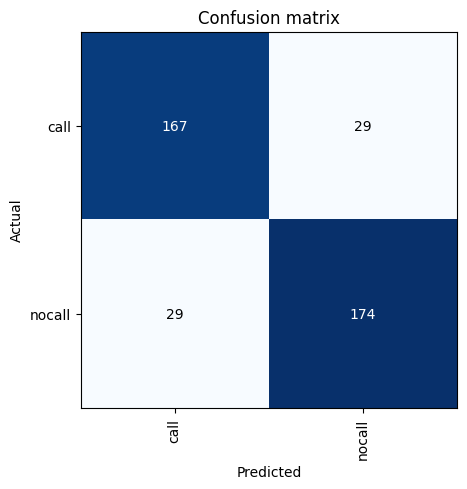

In [ ]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

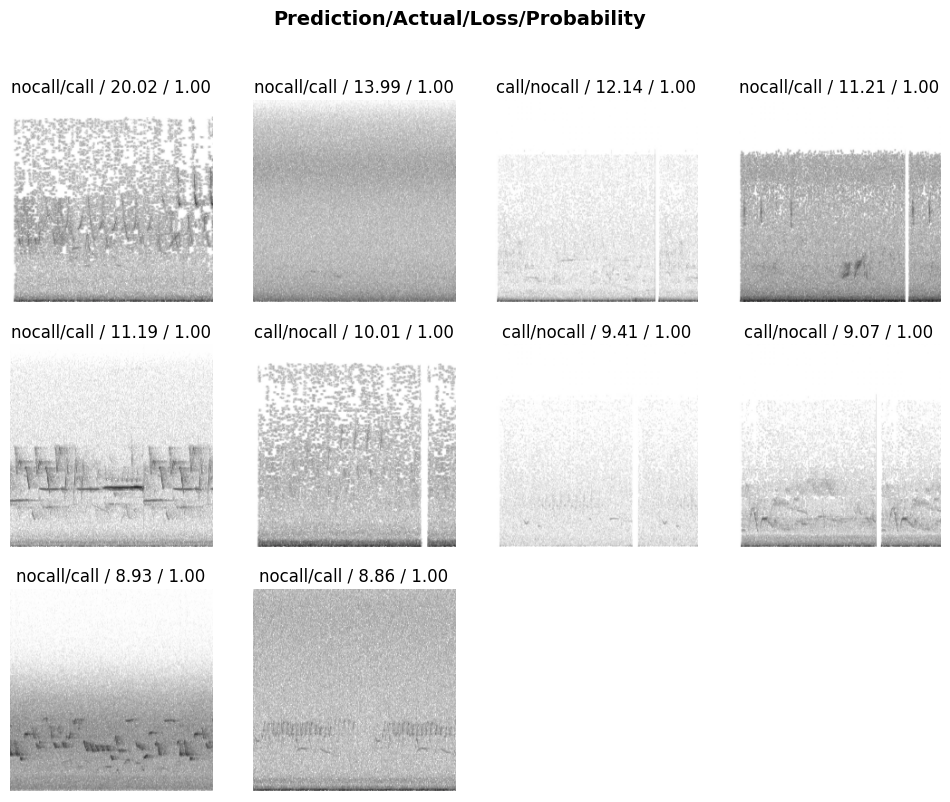

In [ ]:
interpreter.plot_top_losses(10)

In [ ]:
idx = 1

### Iterate through examples one by one to see the model's prediction, the spectrogram and the label

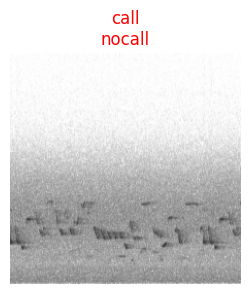

In [ ]:
idx+=1
interpreter.show_results(idx)

Could this one be mis-labelled?

In [ ]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

        call       0.82      0.79      0.81       204
      nocall       0.79      0.82      0.80       195

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399

